This notebook numerically demonstrates some results proved in the second part of my PhD thesis.

We first starts with 2d Radon transform and its inverse, which is the foundation of CT scanning.

We define a simple toy grayscale image $f$ (shown in the left image below) which consists of two intersected circles with different grayscale.

Recall that the Radon transform of a 2d function f $f$, denoted by $\mathcal{R}f$ and is shown in the right image below, is a function defined on all the straight lines (parametrized by $(\theta, s)$) with value equals the line integral of $f$ alone the lines.

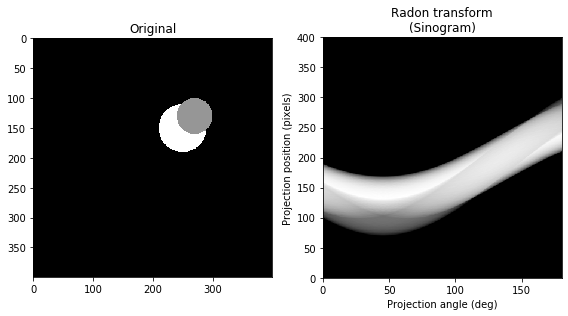

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale

# initialize the original image
image = np.ndarray(shape=(400,400))
for i in range(400):
    for j in range(400):
        if (i-130)**2 + (j-270)**2 <= 900:
            image[i][j] = 1
        elif (i-150)**2 + (j-250)**2 <= 1600:
            image[i][j] = 2
        else:
            image[i][j] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

# calculate its Radon transform and display the two images
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

In CT scanning, the data we have in hand is basically the Radon transform of slices of patient's body, which is the image on the right, what we want is to recover the original function (the image on the left) from its Radon transform.

This has been studied in the early 19th centrury with an algorithm called filtered backprojection and we have
$$f = \mathcal{R}^T\mathcal{F}(\mathcal{R}f),$$
where $\mathcal{F}$ is a filter in Radon domain (which correspond to multiplication in Fourier domain) and $\mathcal{R}^T$ is the Radon transpose (backprojection).

Below is a numerical demonstration for that. We need to point out that FBP is not the algorithm used in most mordern CT machines, instead an iterative method has been widely used nowadays.

FBP rms reconstruction error: 0.0233


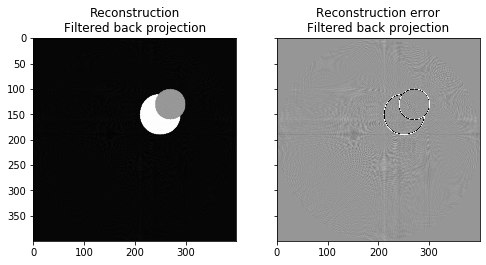

In [130]:
from skimage.transform import iradon

# run filtered backprojection, the recontruction algorithm, calcualte error and display the image
reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

In CT scans, the circles above represent different organs and we are most interested in the boundaries of the organs, which mathematically correspond to the singularities of the original function. We have powerful tools from microlocal analysis to analyze that.

We assume the original function is piecewise regular (like piecewise smooth and can actually be relaxed to piecewise $C^2$) with only jump discontinuouties, then all the singularities of the original function are those boundaries where jumps happen.

It turns out Radon transform is a Fourier integral operator and there have been theoretical results telling us how it will transform the sigularities of the original function to singularities of its Radon transform.

In short, under our assumptions, each boundary in the original function will become singularities (may not be a jump anymore, but maybe not differentiable) alone two conjugate curves in the Radon domain. We can roughly see that in the picture above that there are 4 singular curves in the Radon transform.

Instead of using the FBP, consider the following function
$$g = \Delta\mathcal{R}^T(\mathcal{R}f),$$
which is obtained by apply backprojection directly and then apply a Laplacian operator on it, it can be proved that this new function $g$ shares the same singularities (and even stronger) with the original function $f$ and the technique is called lambda tomography.

We can see this in the example below (where the big circle on the outside is just some numerical artifacts caused by the numerical Radon and its transpose crop the image outside the circle).

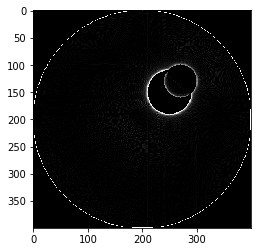

In [5]:
from skimage.transform import iradon
from astropy.visualization import (MinMaxInterval, ImageNormalize)

def laplacian(image):
    #apply discrete Laplacian to the image
    
    #get the size of the image
    m = len(image)
    n = len(image[0])
    
    result = np.copy(image)
    
    #apply laplacian
    for i in range(1,m-1):
        for j in range(1,n-1):
            result[i][j] = image[i+1][j] + image[i-1][j] + image[i][j+1] + image[i][j-1] - 4*image[i][j]  
        
    return result

lambda_tomography = laplacian(iradon(sinogram, theta=theta, filter=None, circle=True))
norm = ImageNormalize(image, interval=MinMaxInterval())

imkwargs = dict(vmin=-0.2, vmax=0.2)
[fig, ax1] = plt.subplots()
ax1.imshow(lambda_tomography, cmap=plt.cm.Greys_r, norm=norm)
plt.show()

Now we move on to PET (positron emission tomography) scan. In a PET scan, there are two unknown functions $f$ and $g$. And the data we have in hand is $\mathcal{R}f e^{-\mathcal{R}g}$ and the goal is to recover $f$.

This is usually done by performing a CT scan which can recover $g$, then we can get $\mathcal{R}f$ and calculate $f$ from that.

In the thesis, we show that if $f$ and $g$ satisfy the same assumption as above and all we want is recover those jump locations (singularities of $f$ and $g$), then it can be achieved using only the PET data so the extra CT scanning is not necessary.

We give two numerical demonstration here. First we show that the singularites in the PET data is actually a combination of the singularities of $f$ and singularities of $g$. Then we apply the lambda tomography technique above and show it can also reveals singularities of $f$ and $g$ together.

We first show $f$ and $g$.

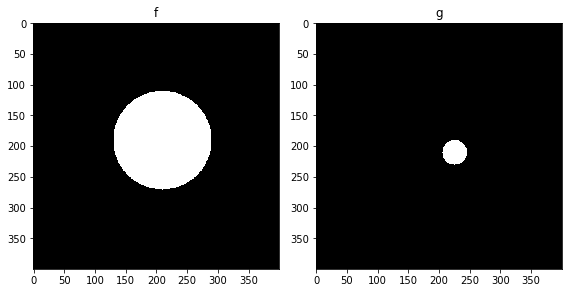

In [7]:
# initialize f and g, display them
f = np.ndarray(shape=(400,400))
for i in range(400):
    for j in range(400):
        if (i-190)**2 + (j-210)**2 <= 6400:
            f[i][j] = 1
        else:
            f[i][j] = 0
            
g = np.ndarray(shape=(400,400))
for i in range(400):
    for j in range(400):
        if (i-210)**2 + (j-225)**2 <= 400:
            g[i][j] = 2
        else:
            g[i][j] = 0
            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("f")
ax1.imshow(f, cmap=plt.cm.Greys_r)

ax2.set_title("g")
ax2.imshow(g, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()

Then we show their Radon transform and the PET data. It can be seen from here that the singularities in PET data is a superposition of those in $f$ and $g$.

So it is possible to extract those singularities from the PET data and then recover the singularities (jump locations) in the original $f$ and $g$.

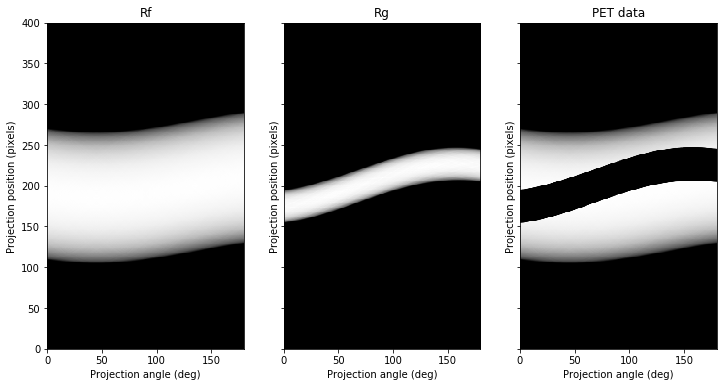

In [8]:
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
Rf = radon(f, theta=theta)
Rg = radon(g, theta=theta)
PETData = np.divide(Rf,np.exp(Rg))            
                 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 6), sharey=True)

ax1.set_title("Rf")
ax1.set_xlabel("Projection angle (deg)")
ax1.set_ylabel("Projection position (pixels)")
ax1.imshow(Rf, cmap=plt.cm.Greys_r,extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

ax2.set_title("Rg")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(Rg, cmap=plt.cm.Greys_r,extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

ax3.set_title("PET data")
ax3.set_xlabel("Projection angle (deg)")
ax3.set_ylabel("Projection position (pixels)")
ax3.imshow(PETData, cmap=plt.cm.Greys_r,extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
plt.show()

In the end, we show the same lambda tomography also works in the PET setting. Though there are some numerical artifacts, we can still see the two circles clearly.

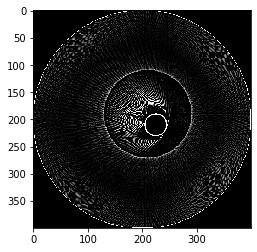

In [9]:
lambda_pet = laplacian(iradon(PETData, theta=theta, filter=None, circle=True))
norm = ImageNormalize(image, interval=MinMaxInterval())

imkwargs = dict(vmin=-0.2, vmax=0.2)
[fig, ax1] = plt.subplots()
ax1.imshow(lambda_pet, cmap=plt.cm.Greys_r, norm=norm)
plt.show()

There are still a lot to be done, including how to implement the boundary recovery result numerically, can we combine these theoretical analysis with machine learning and computer vision techniques to extract those singularities, etc. 